In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all" # cell 的多行输出

LightGBM算法
- 既能做分类分析，对应的模型为LightGBM分类模型（LGBMClassifier）
- 又能做回归分析，对应的模型为LightGBM回归模型（LGBMRegressor）。

# 简单示例

In [1]:
# 分类问题
from lightgbm import LGBMClassifier
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 0, 0, 1, 1]
model=LGBMClassifier()
model.fit(X,y)
model.predict([[5,5]])

array([0])

In [3]:
# 回归问题
from lightgbm import LGBMRegressor
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 2, 3, 4, 5]
model=LGBMRegressor()
model.fit(X,y)
model.predict([[5,5]])

array([3.])

# 客户违约预测模型

银行等金融机构经常会根据客户的个人资料、财产等情况，来预测借款客户是否会违约，以便进行贷前审核、贷中管理、贷后违约处理等工作。金融处理的就是风险，需要在风险和收益之间寻求一个平衡点，现代金融在某种程度上是一个风险定价的过程。通过海量数据对客户进行风险评估并进行合适的借款利率定价，这便是一个典型的风险定价过程，又称为大数据风控。

In [4]:
import pandas as pd
df=pd.read_excel('./data/客户信息及违约表现.xlsx')
df.head()

,收入,年龄,性别,历史授信额度,历史违约次数,是否违约
0,462087,26,1,0,1,1
1,362324,32,0,13583,0,1
2,332011,52,1,0,1,1
3,252895,39,0,0,1,1
4,352355,50,1,0,0,1


LGBMClassifier()

accuracy:0.78


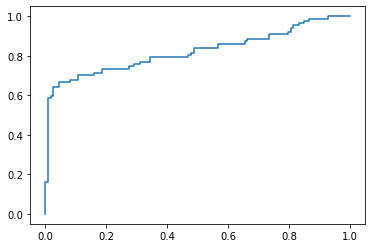

auc:0.8221950971416945


,特征名称,特征重要性
0,收入,1175
3,历史授信额度,895
1,年龄,668
4,历史违约次数,126
2,性别,118


In [8]:
X=df.drop(columns='是否违约')
y=df['是否违约']
# 数据划分
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
# 模型训练
from lightgbm import LGBMClassifier
model=LGBMClassifier()
model.fit(X_train,y_train)
# 模型预测
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)
# accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)
print("accuracy:{}".format(score))
# roc 曲线
from sklearn.metrics import roc_curve
fpr,tpr,thres=roc_curve(y_test,y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.show();
# auc
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_test,y_pred_proba[:,1])
print('auc:{}'.format(auc))
# 特征重要性
features=X.columns
importances=model.feature_importances_
importances_df=pd.DataFrame()
importances_df['特征名称']=features
importances_df['特征重要性']=importances
importances_df.sort_values('特征重要性',ascending=False)

模型调优,选取如下:

- num_leaves：决策树的最大叶子节点数，即决策树最多有多少个叶子节点，默认取31。因为LightGBM模型使用的是leaf-wise生长策略，所以在调节树的复杂度时常用的参数是num_leaves，而不是树的最大深度参数max_depth。
- n_estimators：弱学习器的个数，或者说是弱学习器的最大迭代次数，默认取100。
- learning_rate：学习率，又称为每个弱学习器的权重缩减系数，取值范围为（0，1]，默认取0.1。取值较小意味着要达到一定的误分类数或学习效果，需要更多迭代次数和更多弱学习器

In [9]:
from symbol import parameters
from sklearn.model_selection import GridSearchCV
parameters={'num_leaves':[10,15,31],'n_estimators':[10,20],'learning_rate':[0.05,0.1,0.2]}
model=LGBMClassifier()
grid_search=GridSearchCV(model,parameters,scoring='roc_auc',cv=5)
grid_search.fit(X_train,y_train)
grid_search.best_params_

C:\Users\26598\AppData\Local\Temp/ipykernel_24304/1401189464.py:1: DeprecationWarning: The symbol module is deprecated and will be removed in future versions of Python
  from symbol import parameters


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [10, 20], 'num_leaves': [10, 15, 31]},
             scoring='roc_auc')

{'learning_rate': 0.2, 'n_estimators': 10, 'num_leaves': 10}

In [11]:
model=LGBMClassifier(learning_rate=0.2,n_estimators=10,num_leaves=10)
model.fit(X_train,y_train)
y_pred_proba=model.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
score=roc_auc_score(y_test,y_pred_proba[:,1])
print('auc:{}'.format(score))

LGBMClassifier(learning_rate=0.2, n_estimators=10, num_leaves=10)

auc:0.8712236801953005
